In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(42)

In [4]:
import scipy.stats
from tqdm import tqdm


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(4))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 8 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [5]:
import open_clip
import clip
from open_clip import tokenizer

clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)

clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [6]:
classes = {}

with open("./datasets/cifar10/labels.txt", "r") as f:
    cls_names = f.read().lower().split("\n")

for i, cls_name in enumerate(cls_names):
    classes[i] = cls_name

del classes[10]

print(classes)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# image encodings

In [7]:
path_to_im = "./datasets/cifar10/train"
image_dirs = [path_to_im + "/{}/".format(cls) for cls in classes.values()]
N = 50 # how many images of every class to take
selected_images = []

for dir in image_dirs:
    filenames = os.listdir(dir)
    upd_filenames = [dir + f for f in filenames]
    selected_images.append(sorted(upd_filenames[:N]))

selected_images = [item for sublist in selected_images for item in sublist]

In [8]:
image_inputs = []

for name in tqdm(selected_images):
    im = Image.open(name)
    im_input = preprocess(im).unsqueeze(0).to(device)
    image_inputs.append(im_input)

image_inputs = torch.stack(image_inputs, dim=0)

100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.55it/s]


In [9]:
image_encodings = []

with torch.no_grad():
    for image in tqdm(image_inputs):
        image_feature = clip_model.encode_image(image)
        image_encodings.append(image_feature)

image_features = torch.stack(image_encodings, dim=0)

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.11it/s]


# text encodings

In [10]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

with open("all_concepts.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

In [11]:
concept_encodings = []

with torch.no_grad():
    for c in tqdm(concepts):
        text_input = clip.tokenize(c).to(device)
        text_feature = clip_model.encode_text(text_input)
        concept_encodings.append(text_feature)

concept_features = torch.stack(concept_encodings, dim=0)

100%|██████████████████████████████████████| 5051/5051 [00:39<00:00, 127.26it/s]


In [12]:
class_encodings = []

with torch.no_grad():
    for cls in classes.values():
        text_input = clip.tokenize(cls).to(device)
        text_feature = clip_model.encode_text(text_input)
        class_encodings.append(text_feature)

class_features = torch.stack(class_encodings, dim=0)

In [13]:
print(f"Image features shape is {image_features.shape}", "\n")
print(f"Concept features shape is {concept_features.shape}", "\n")
print(f"Classes features shape is {class_features.shape}")

Image features shape is torch.Size([500, 1, 512]) 

Concept features shape is torch.Size([5051, 1, 512]) 

Classes features shape is torch.Size([10, 1, 512])


# im-text and im-concept matrices

In [14]:
from embeds_utils import *

In [15]:
V_matrix = get_dot_prods_matrix(image_features, concept_features)
T_matrix = get_dot_prods_matrix(class_features, concept_features)

print('V_matrix:', V_matrix.shape, "\n")
print('T_matrix:', T_matrix.shape)

V_matrix: torch.Size([500, 5051]) 

T_matrix: torch.Size([10, 5051])


# draw TSNE

In [48]:
#import bokeh.models as bm, bokeh.plotting as pl
#from bokeh.io import output_notebook

output_notebook()
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Loading BokehJS ...

In [20]:
image_names = []
for name in tqdm(selected_images):
    upd_name = name.split('_')[1].split('.')[0]
    image_names.append(upd_name)

100%|█████████████████████████████████████| 500/500 [00:00<00:00, 201668.62it/s]


In [40]:
# features to be drawn
image_features_iv = image_features.squeeze(dim=1).cpu()
class_features_wv = class_features.squeeze(dim=1).cpu()
concept_features_wv = concept_features.squeeze(dim=1).cpu()

# names for points
all_names = image_names + concepts + list(classes.values())

# colors for points
image_colors = ['red'] * len(image_features_iv)
concept_colors = ['green'] * len(concept_features_wv)
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + concept_colors + class_colors

In [49]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, concept_features_wv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=50)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=all_names)

figure(id='p1050', ...)

# similarities

In [18]:
def generate_slices_for_classes(num_classes, slice_size):
    """
    num_classes: amount of classes in dataset
    slice_size: how many rows does a particular class occupy in V_matrix
    return: slices for every class
    """
    slices = {}
    for i, class_idx in enumerate(classes):
        start = i * slice_size
        end = (i + 1) * slice_size
        slices[classes[class_idx]] = slice(start, end)
    return slices

def calculate_similarity_score(V_rows: torch.Tensor, T_matrix: torch.Tensor):
    """
    V_rows: a rows of V_matrix for the same class
    T_matrix: yeap
    return: a dictionary with similarity scores for each class
    """
    scores = {}
    
    for v_row in V_rows:
        for i in range(len(T_matrix)):
            t_row = T_matrix[i]
            sim = similarity(v_row, t_row)
            class_name = classes[i]
            
            if class_name in scores:
                scores[class_name] += sim.item()
            else:
                scores[class_name] = sim.item()
            
    return scores

def calculate_cubed_similarity_score(V_rows: torch.Tensor, T_matrix: torch.Tensor):
    """
    V_rows: a rows of V_matrix for the same class
    T_matrix: yeap
    return: a dictionary with similarity scores for each class
    """
    scores = {}
    
    for v_row in V_rows:
        for i in range(len(T_matrix)):
            t_row = T_matrix[i]
            sim = cubed_similarity(v_row, t_row)
            class_name = classes[i]
            
            if class_name in scores:
                scores[class_name] += sim.item()
            else:
                scores[class_name] = sim.item()
            
    return scores

def draw_similarity_scores(scores_dict, true_class):
    """
    scores_dict: a nested dictionary with similarity scores
    true_class: the true image class for which scores should be plotted
    """
    
    if true_class not in scores_dict:
        print(f"True class '{true_class}' not found in the scores dictionary.")
        return
    
    scores = scores_dict[true_class]
    df = pd.DataFrame(list(scores.items()), columns=['Class', 'Total Similarity Score'])
    
    plt.figure(figsize=(6, 3)) # 12 6
    sns.scatterplot(data=df, x='Class', y='Total Similarity Score')
    plt.title(f"Similarity Scores for True Class: {true_class}")
    plt.xticks(rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Total Similarity Score")
    plt.tight_layout()
    plt.show()

get scores dict

In [28]:
scores_dict = {}

num_classes = len(classes)
slice_size = len(V_matrix) // num_classes
slices = generate_slices_for_classes(num_classes, slice_size)

for class_name, slice_range in slices.items():
    V_rows = V_matrix[slice_range]
    scores = calculate_similarity_score(V_rows, T_matrix)
    scores_dict[class_name] = scores

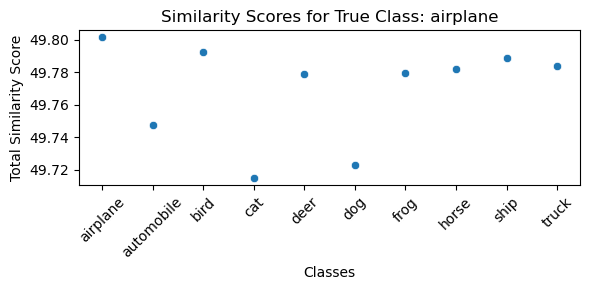

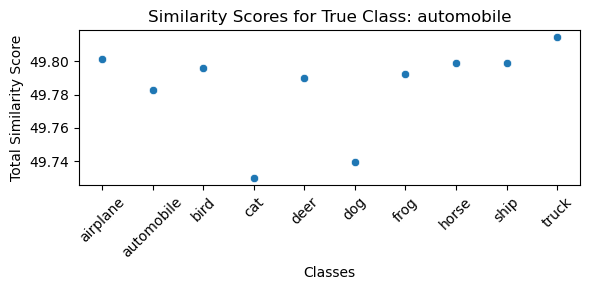

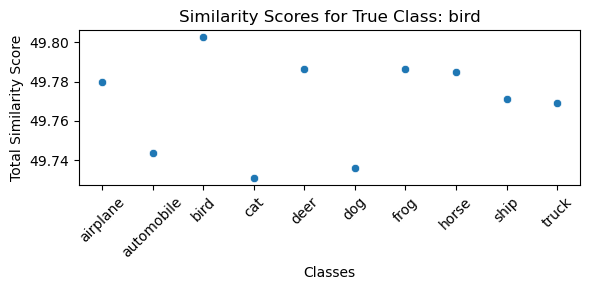

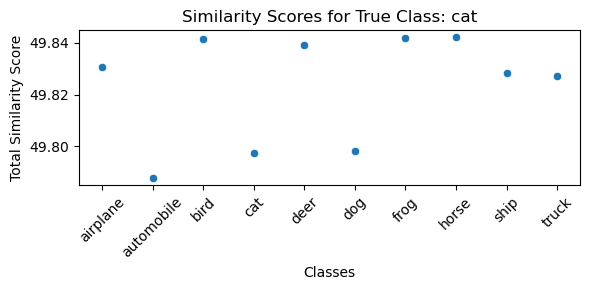

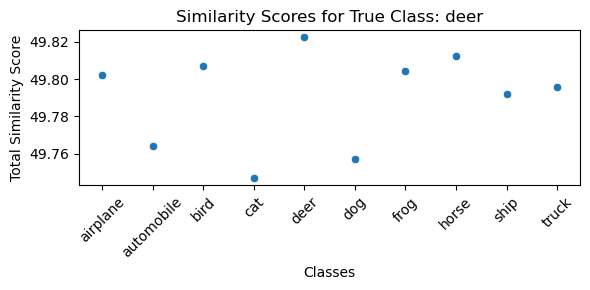

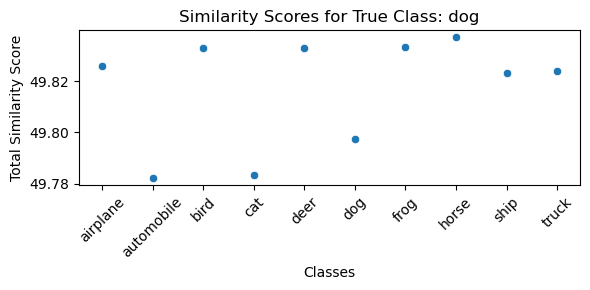

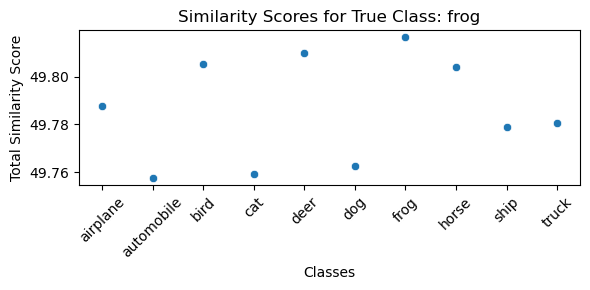

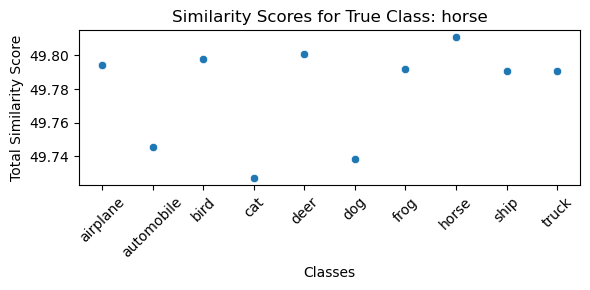

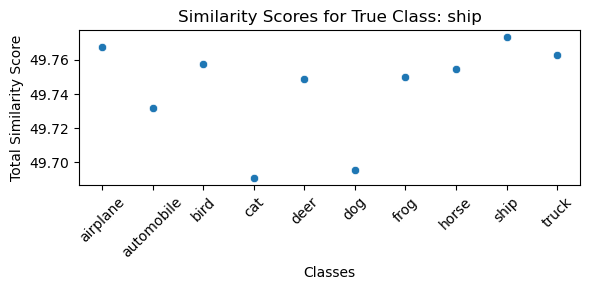

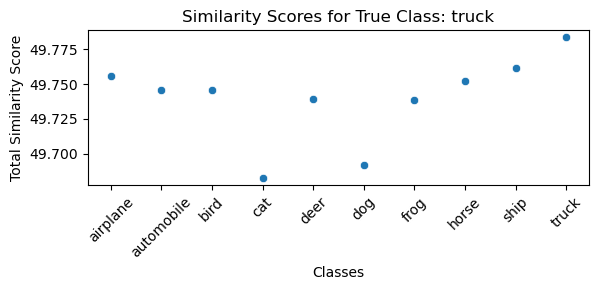

In [18]:
for class_name in scores_dict.keys():
    draw_similarity_scores(scores_dict, class_name)

## tests with similarity and cubed similarity

In [72]:
scores_dict = {}

num_classes = len(classes)
slice_size = len(V_matrix) // num_classes
slices = generate_slices_for_classes(num_classes, slice_size)

for class_name, slice_range in slices.items():
    V_rows = V_matrix[slice_range]
    scores = calculate_cubed_similarity_score(V_rows, T_matrix)
    scores_dict[class_name] = scores

In [87]:
def draw_few_similarity_scores(sim_scores_dict, cubedsim_scores_dict, true_class):
   # """
   # scores_dict: a nested dictionary with similarity scores
   # true_class: the true image class for which scores should be plotted
   # """
    
    if true_class not in sim_scores_dict:
        print(f"True class '{true_class}' not found in the scores dictionary.")
        return
    
    if true_class not in cubedsim_scores_dict:
        print(f"True class '{true_class}' not found in the scores dictionary.")
        return
    
    scores = sim_scores_dict[true_class]
    sim_df = pd.DataFrame(list(scores.items()), columns=['Class', 'Total Similarity Score'])
    
    cubedscores = cubedsim_scores_dict[true_class]
    cubed_df = pd.DataFrame(list(cubedscores.items()), columns=['Class', 'Total Similarity Score'])
    
    plt.figure(figsize=(6, 3)) # 12 6
    sns.scatterplot(data=sim_df, x='Class', y='Total Similarity Score')
    sns.scatterplot(data=cubed_df, x='Class', y='Total Similarity Score')
    plt.title(f"Similarity Scores for True Class: {true_class}")
    plt.xticks(rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Total Similarity Score")
    plt.tight_layout()
    plt.show()

In [85]:
sim_scores_dict = {}

num_classes = len(classes)
slice_size = len(V_matrix) // num_classes
slices = generate_slices_for_classes(num_classes, slice_size)

for class_name, slice_range in slices.items():
    V_rows = V_matrix[slice_range]
    scores = calculate_similarity_score(V_rows, T_matrix)
    sim_scores_dict[class_name] = scores

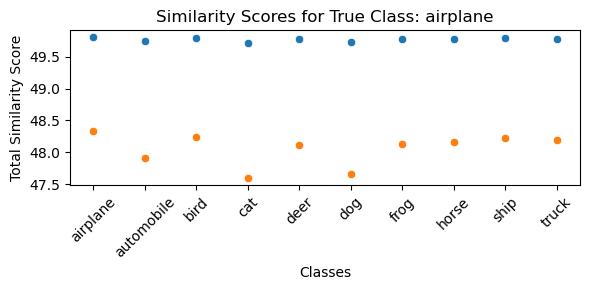

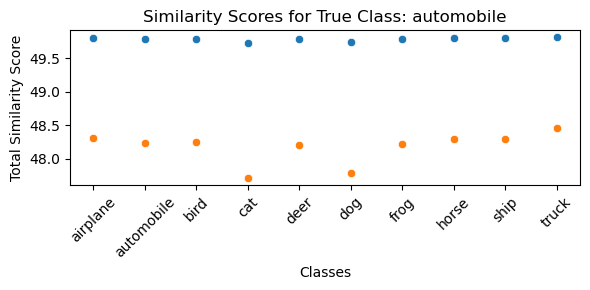

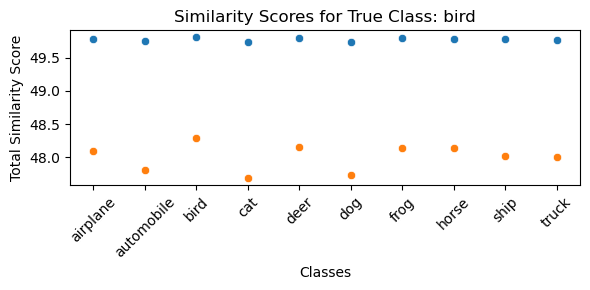

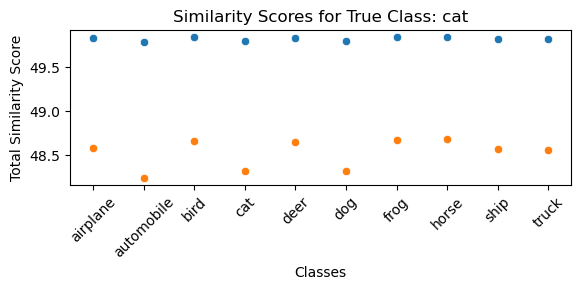

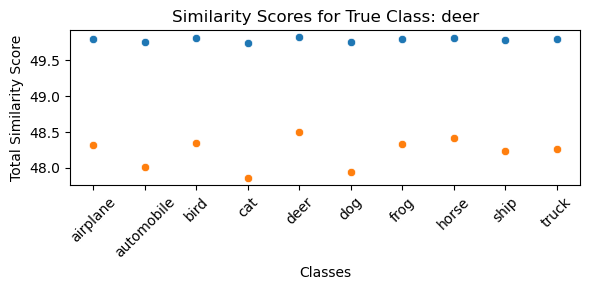

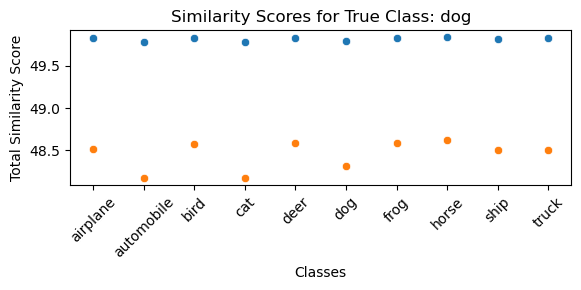

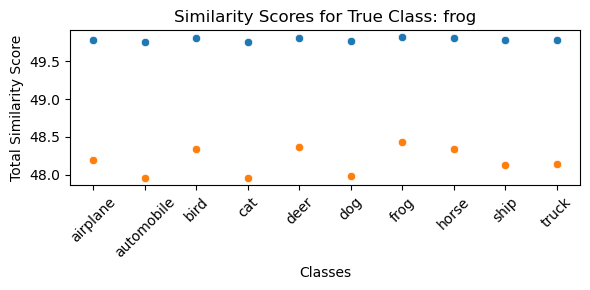

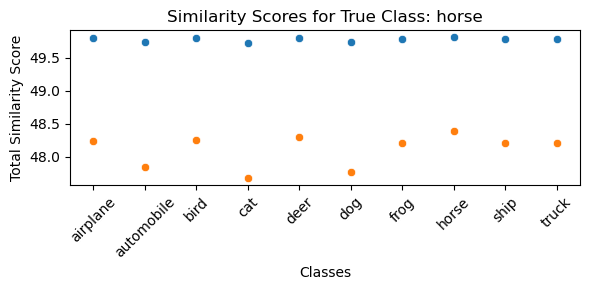

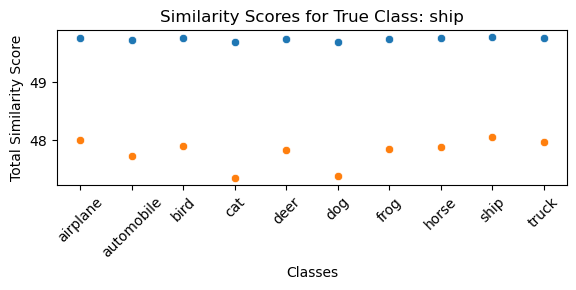

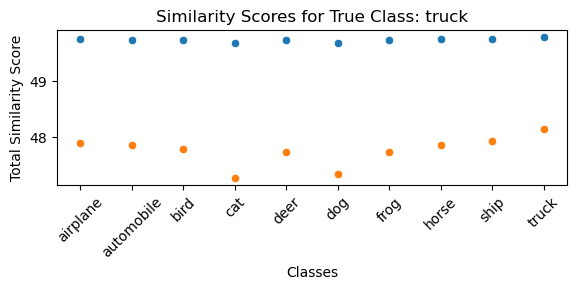

In [88]:
cubedsim_scores_dict = scores_dict
for class_name in scores_dict.keys():
    draw_few_similarity_scores(sim_scores_dict, cubedsim_scores_dict, class_name)

# tests with maximum score

In [53]:
def calculate_max_score_accuracy_for_class(class_name: str, V_matrix: torch.Tensor, T_matrix: torch.Tensor):
    """
    V_rows: a rows of V_matrix for the same class
    T_matrix: yeap
    return: a dictionary with so-called max scores for each class
    """
    
    slice_size = len(V_matrix) // len(classes)
    slices = generate_slices_for_classes(len(classes), slice_size)
    slice_range = slices[class_name]
    V_rows = V_matrix[slice_range]
    
    correct, total = 0, 0
    
    for v_row in V_rows:
        max_elem_idx = torch.argmax(v_row).item()
        
        t_matrix_column = T_matrix[:, max_elem_idx]
        t_max_elem_idx = torch.argmax(t_matrix_column).item()
        
        if classes[t_max_elem_idx] == class_name:
            correct += 1
            
        total += 1
        
    return f"accurary for the class {class_name} is {100 * correct / total}%"

In [26]:
for class_name in classes.values():
    print(calculate_max_score_accuracy_for_class(class_name, V_matrix, T_matrix))

accurary for the class airplane is 18.0%
accurary for the class automobile is 14.0%
accurary for the class bird is 84.0%
accurary for the class cat is 40.0%
accurary for the class deer is 74.0%
accurary for the class dog is 32.0%
accurary for the class frog is 52.0%
accurary for the class horse is 94.0%
accurary for the class ship is 100.0%
accurary for the class truck is 80.0%


## tests with another (smaller) concept set

In [42]:
with open("conceptnet_cifar10_filtered_new.txt", "r") as f:
    small_concepts = f.read().lower().split("\n")
    small_concepts = remove_prefixes(small_concepts)
    
small_concept_encodings = []
with torch.no_grad():
    for c in tqdm(small_concepts):
        text_input = clip.tokenize(c).to(device)
        text_feature = clip_model.encode_text(text_input)
        small_concept_encodings.append(text_feature)

small_concept_features = torch.stack(small_concept_encodings, dim=0)

V_matrix_small = get_dot_prods_matrix(image_features, small_concept_features)
T_matrix_small = get_dot_prods_matrix(class_features, small_concept_features)
print('V_matrix:', V_matrix_small.shape, "\n")
print('T_matrix:', T_matrix_small.shape)

100%|████████████████████████████████████████| 120/120 [00:00<00:00, 132.24it/s]


V_matrix: torch.Size([500, 120]) 

T_matrix: torch.Size([10, 120])


In [43]:
for class_name in classes.values():
    print(calculate_max_score_accuracy_for_class(class_name, V_matrix_small, T_matrix_small))

accurary for the class airplane is 18.0%
accurary for the class automobile is 44.0%
accurary for the class bird is 78.0%
accurary for the class cat is 0.0%
accurary for the class deer is 6.0%
accurary for the class dog is 2.0%
accurary for the class frog is 38.0%
accurary for the class horse is 98.0%
accurary for the class ship is 100.0%
accurary for the class truck is 76.0%


## specific concepts test

In [72]:
with open("gpt_cifar10_filtered_new.txt", "r") as f:
    gpt_concepts = f.read().lower().split("\n")
    gpt_concepts = remove_prefixes(gpt_concepts)
    
gpt_concept_encodings = []
with torch.no_grad():
    for c in tqdm(gpt_concepts):
        text_input = clip.tokenize(c).to(device)
        text_feature = clip_model.encode_text(text_input)
        gpt_concept_encodings.append(text_feature)

gpt_concept_features = torch.stack(gpt_concept_encodings, dim=0)

V_matrix_gpt = get_dot_prods_matrix(image_features, gpt_concept_features)
T_matrix_gpt = get_dot_prods_matrix(class_features, gpt_concept_features)
print('V_matrix:', V_matrix_gpt.shape, "\n")
print('T_matrix:', T_matrix_gpt.shape)

100%|██████████████████████████████████████████| 76/76 [00:00<00:00, 130.00it/s]


V_matrix: torch.Size([500, 76]) 

T_matrix: torch.Size([10, 76])


In [45]:
for class_name in classes.values():
    print(calculate_max_score_accuracy_for_class(class_name, V_matrix_gpt, T_matrix_gpt))

accurary for the class airplane is 30.0%
accurary for the class automobile is 0.0%
accurary for the class bird is 88.0%
accurary for the class cat is 10.0%
accurary for the class deer is 18.0%
accurary for the class dog is 24.0%
accurary for the class frog is 50.0%
accurary for the class horse is 94.0%
accurary for the class ship is 100.0%
accurary for the class truck is 96.0%


comparing

In [68]:
comparing_dict = {}

for class_name in classes.values():
    big = calculate_max_score_accuracy_for_class(class_name, V_matrix, T_matrix)
    small = calculate_max_score_accuracy_for_class(class_name, V_matrix_small, T_matrix_small)
    gpt = calculate_max_score_accuracy_for_class(class_name, V_matrix_gpt, T_matrix_gpt)
    
    big = ''.join(char if char.isdigit() or char == '.' else ' ' for char in big).split()
    small = ''.join(char if char.isdigit() or char == '.' else ' ' for char in small).split()
    gpt = ''.join(char if char.isdigit() or char == '.' else ' ' for char in gpt).split()
    
    comparing_dict[class_name] = [''.join(big), ''.join(small), ''.join(gpt)]

In [69]:
comparing_dict

{'airplane': ['18.0', '18.0', '30.0'],
 'automobile': ['14.0', '44.0', '0.0'],
 'bird': ['84.0', '78.0', '88.0'],
 'cat': ['40.0', '0.0', '10.0'],
 'deer': ['74.0', '6.0', '18.0'],
 'dog': ['32.0', '2.0', '24.0'],
 'frog': ['52.0', '38.0', '50.0'],
 'horse': ['94.0', '98.0', '94.0'],
 'ship': ['100.0', '100.0', '100.0'],
 'truck': ['80.0', '76.0', '96.0']}

one more set

In [80]:
spec_concepts = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog ", "horse", "ship", "truck"]

spec_concept_encodings = []
with torch.no_grad():
    for c in tqdm(spec_concepts):
        text_input = clip.tokenize(c).to(device)
        text_feature = clip_model.encode_text(text_input)
        spec_concept_encodings.append(text_feature)

spec_concept_features = torch.stack(spec_concept_encodings, dim=0)

V_matrix_spec = get_dot_prods_matrix(image_features, spec_concept_features)
T_matrix_spec = get_dot_prods_matrix(class_features, spec_concept_features)
print('V_matrix:', V_matrix_spec.shape, "\n")
print('T_matrix:', T_matrix_spec.shape)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 66.20it/s]


V_matrix: torch.Size([500, 10]) 

T_matrix: torch.Size([10, 10])


In [81]:
for class_name in classes.values():
    print(calculate_max_score_accuracy_for_class(class_name, V_matrix_spec, T_matrix_spec))

accurary for the class airplane is 84.0%
accurary for the class automobile is 80.0%
accurary for the class bird is 92.0%
accurary for the class cat is 76.0%
accurary for the class deer is 84.0%
accurary for the class dog is 86.0%
accurary for the class frog is 80.0%
accurary for the class horse is 96.0%
accurary for the class ship is 98.0%
accurary for the class truck is 96.0%


# tests with random words

In [90]:
!pip install random-word

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.4 MB/s eta 0:00:0000:010:01


In [59]:
from random_word import RandomWords
randomword = RandomWords()

random_words = []

for i in range(5000):
    random_words.append(randomword.get_random_word())

In [60]:
randwords_encodings = []

with torch.no_grad():
    for rw in tqdm(random_words):
        text_input = clip.tokenize(rw).to(device)
        text_feature = clip_model.encode_text(text_input)
        randwords_encodings.append(text_feature)

randwords_features = torch.stack(randwords_encodings, dim=0)

100%|██████████████████████████████████████| 5000/5000 [00:48<00:00, 102.55it/s]


In [61]:
V_matrix = get_dot_prods_matrix(image_features, randwords_features)
T_matrix = get_dot_prods_matrix(class_features, randwords_features)

print('V_matrix:', V_matrix.shape, "\n")
print('T_matrix:', T_matrix.shape)

V_matrix: torch.Size([500, 5000]) 

T_matrix: torch.Size([10, 5000])


In [104]:
# features to be drawn
image_features_iv = image_features.squeeze(dim=1).cpu()
class_features_wv = class_features.squeeze(dim=1).cpu()
randwords_features_wv = randwords_features.squeeze(dim=1).cpu()

# names for points
all_names = image_names + random_words + list(classes.values())

# colors for points
image_colors = ['red'] * len(image_features_iv)
randwors_colors = ['yellow'] * len(randwords_features_wv)
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + randwors_colors + class_colors

In [105]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, randwords_features_wv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=50)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=all_names)

figure(id='p1095', ...)

In [106]:
all_names = image_names + random_words + concepts + list(classes.values())
colors = image_colors + randwors_colors + concept_colors +class_colors

scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, randwords_features_wv, concept_features_wv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=50)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=all_names)

figure(id='p1140', ...)

In [108]:
scores_dict = {}

num_classes = len(classes)
slice_size = len(V_matrix) // num_classes
slices = generate_slices_for_classes(num_classes, slice_size)

for class_name, slice_range in slices.items():
    V_rows = V_matrix[slice_range]
    scores = calculate_similarity_score(V_rows, T_matrix)
    scores_dict[class_name] = scores

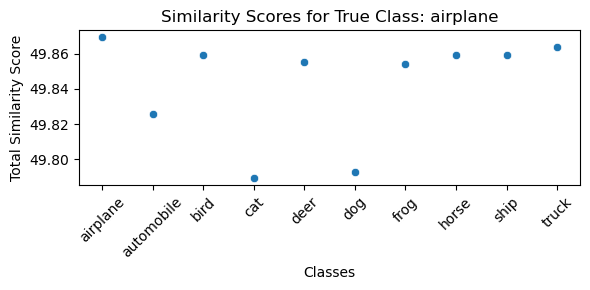

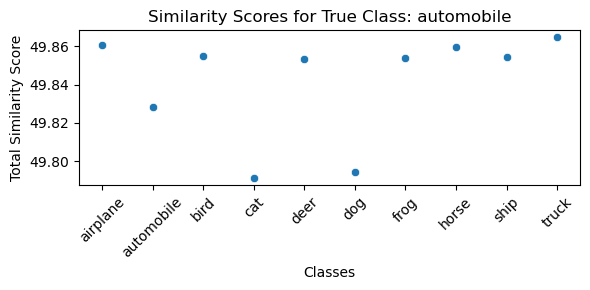

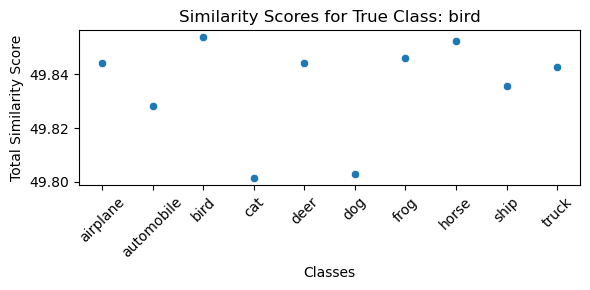

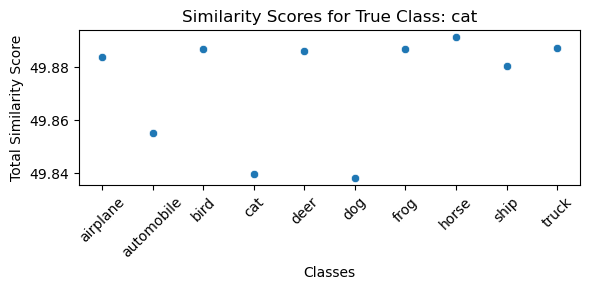

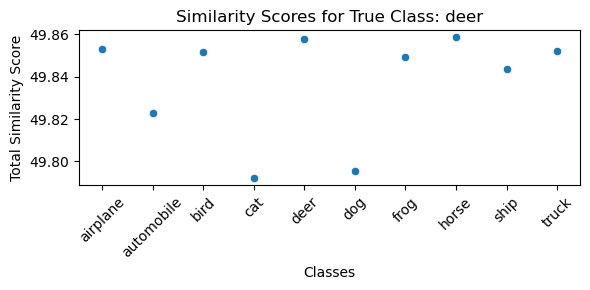

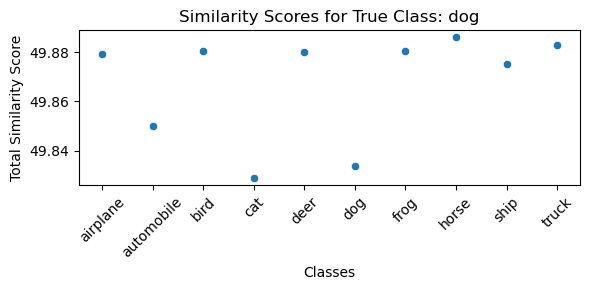

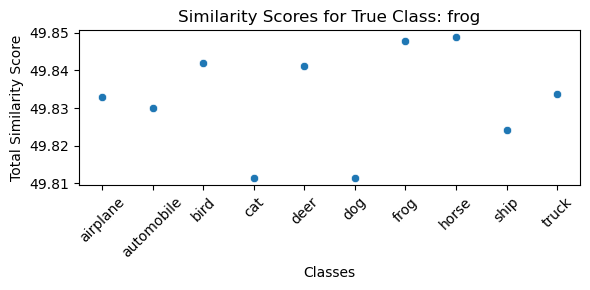

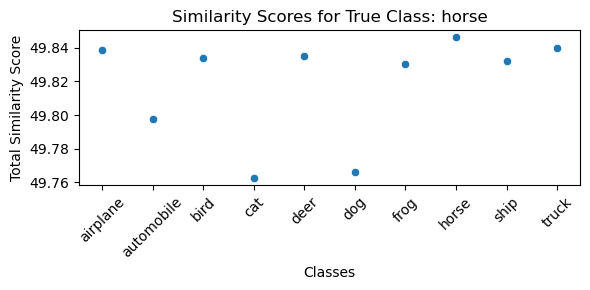

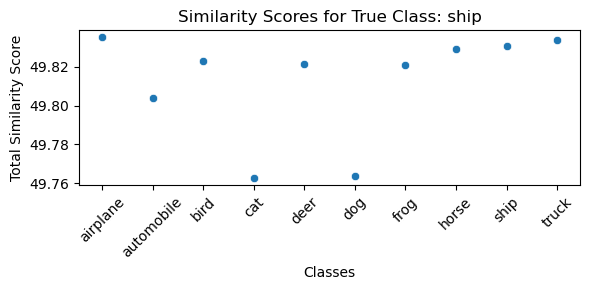

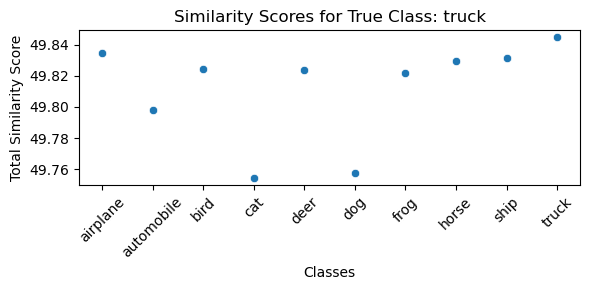

In [109]:
for class_name in scores_dict.keys():
    draw_similarity_scores(scores_dict, class_name)

# classification accuracy with concepts

In [27]:
def calc_accuracy(class_name: str):
    correct = 0.0
    total = 0.0
    
    slice_range = slices[class_name]
    sim_matrix = torch.zeros((V_matrix[slice_range].shape[0], T_matrix.shape[0]))
    
    for i, v_row in enumerate(V_matrix[slice_range]):
        for j, t_row in enumerate(T_matrix):
            sim_matrix[i, j] = similarity(v_row, t_row).item()
            
    for idx in range(sim_matrix.shape[0]):
        pred_idx = torch.argmax(sim_matrix[idx])
        if pred_idx == list(classes.values()).index(class_name):
            correct += 1.0
        total += 1.0
        
    return f"accuracy for the class {class_name} is {100 * correct / total}%"

In [30]:
for class_name in classes.values():
    print(calc_accuracy(class_name))

accuracy for the class airplane is 80.0%
accuracy for the class automobile is 0.0%
accuracy for the class bird is 88.0%
accuracy for the class cat is 0.0%
accuracy for the class deer is 92.0%
accuracy for the class dog is 0.0%
accuracy for the class frog is 72.0%
accuracy for the class horse is 92.0%
accuracy for the class ship is 86.0%
accuracy for the class truck is 100.0%


# classification accuracy with random words

In [62]:
for class_name in classes.values():
    print(calc_accuracy(class_name))

accuracy for the class airplane is 72.0%
accuracy for the class automobile is 0.0%
accuracy for the class bird is 46.0%
accuracy for the class cat is 0.0%
accuracy for the class deer is 20.0%
accuracy for the class dog is 0.0%
accuracy for the class frog is 32.0%
accuracy for the class horse is 76.0%
accuracy for the class ship is 4.0%
accuracy for the class truck is 98.0%
